In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

**Data preprocessing and descriptive analysis**

In [3]:
file_path = "AB_Test_Results.csv"

# Load the latest version of the file
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sergylog/ab-test-data",
  file_path,
)

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [ ]:
# Drop duplicated rows
df = df.drop_duplicates(subset=['USER_ID', 'REVENUE']).reset_index(drop=True)
df['has_churned'] = [0 if row > 0 else 1 for row in df['REVENUE']]

Create synthetic data:

In [6]:
np.random.seed(42)
n = 2000
income_bracket = np.random.choice(
    ['<50k', '50k-99k', '100k-149k', '150k-199k', '>200k'],
    size = n,
    p = [0.25,0.30,0.25,0.15,0.05]
)

# Create other variables from survey using both the Kaggle data and synthetic data

current_status = df['has_churned'].sample(n=n, replace=True) # from the Kaggle dataset

# Internal factors 
benefit_value = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
customer_service = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
product_variety = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
membership_fee = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])

# External factors (scale 1–5)
inflation_pressure = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
trend_switching = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
competition = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])

# NPS score (scale 0–10)
nps_score = np.random.choice(range(11), size = n, p=[0.02, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12, 0.15, 0.23, 0.20, 0.05])

# Overall satisfaction
satisfaction = np.random.choice(range(11), size=n, p=[0.02, 0.02, 0.04, 0.03, 0.08, 0.06, 0.12, 0.23, 0.20, 0.15, 0.05])

# Frequency of use -- assume that mean frequency of use is 2x per week
freq = np.random.poisson(lam=2, size=n)

# Churn reason and dict 
churn_dict = {
    0: 'Membership not worth the cost',
    1: 'Did not use benefits enough',
    2: 'Poor customer service',
    3: 'Lack of product variety',
    4: 'Found better alternative',
    5: 'Budget concerns due to inflation',
    6: 'Seeking new brands',
    7: 'Other',
    8: 'N/A'
}

# Create dataframe
survey_df = pd.DataFrame({
    'Income': income_bracket,
    'Status': current_status,
    'BenefitValue': benefit_value,
    'CustomerService': customer_service,
    'ProductVariety': product_variety,
    'MembershipFee': membership_fee,
    'InflationPressure': inflation_pressure,
    'TrendSwitching': trend_switching,
    'Competition': competition,
    'Satisfaction': satisfaction,
    'FreqUse': freq,
    'NPS': nps_score,
    
})

survey_df['ChurnReason'] = [int(np.random.randint(low=0,high=8,size=1)) if row==1 else 8 for row in survey_df['Status']]

survey_df = survey_df.reset_index(drop=True)
survey_df['Condition'] = survey_df.index.map(lambda i: 'Treatment' if i % 2 == 0 else 'Control')


In [7]:
survey_df.describe()

,Status,BenefitValue,CustomerService,ProductVariety,MembershipFee,InflationPressure,TrendSwitching,Competition,Satisfaction,FreqUse,NPS,ChurnReason
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,0.973500,1.480500,1.492500,1.527000,1.496500,1.51800,1.516000,1.473500,6.571000,2.069500,6.715000,3.55450
std,0.160657,1.138098,1.149611,1.159286,1.151803,1.15297,1.165943,1.151504,2.307948,1.431675,2.351497,2.37589
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,0.750000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,5.000000,1.000000,5.000000,1.00000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,2.00000,2.000000,1.000000,7.000000,2.000000,7.000000,4.00000
75%,1.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,8.000000,3.000000,8.000000,6.00000
max,1.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,10.000000,9.000000,10.000000,8.00000


We now generate some visualizations: 

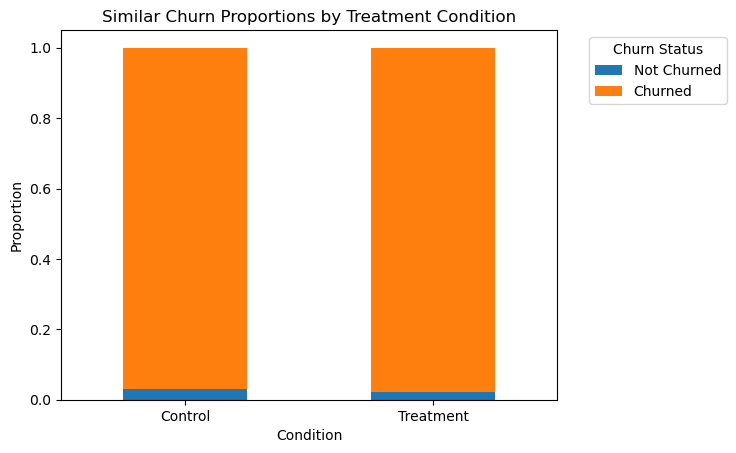

In [8]:
# Plot the proportion of status in the treatment and control groups
props = survey_df.groupby(['Condition','Status']).agg({'Status':'count'})
group_sum = props.groupby('Condition').sum()
props = props.div(group_sum, level = 'Condition')
props = props.rename(columns = {'Status': 'Proportion'})
props = props.reset_index()
props = props.pivot(index='Condition', columns='Status', values='Proportion')

props.plot(kind='bar', stacked=True)
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.title('Similar Churn Proportions by Treatment Condition')
plt.legend(labels=['Not Churned','Churned'], title='Churn Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

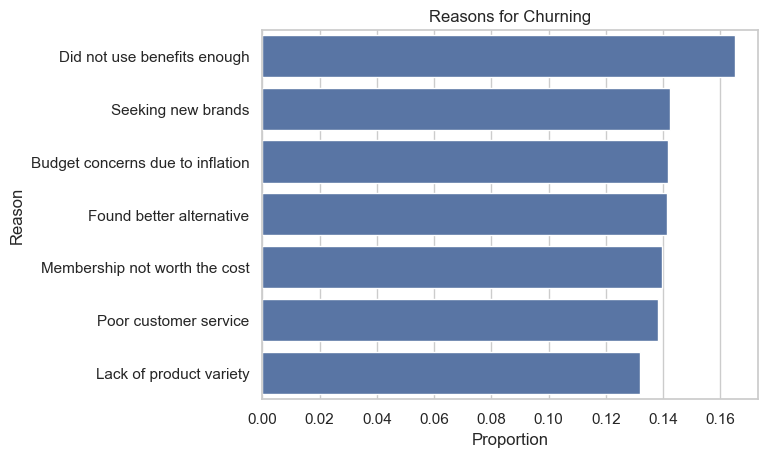

In [122]:
# Plot proportion of churn reasons
churn_reasons = survey_df['ChurnReason'].value_counts()
churn_reasons = churn_reasons[0:7,]
churn_reasons = churn_reasons.reset_index()
churn_reasons['Reason'] = churn_reasons['ChurnReason'].map(churn_dict)
churn_reasons = churn_reasons.drop(columns='ChurnReason')
churn_reasons['Prop'] = churn_reasons['count'] / churn_reasons['count'].sum()
fig,ax=plt.subplots()
sns.barplot(data=churn_reasons, x='Prop', y='Reason')
plt.xlabel("Proportion")
plt.title("Reasons for Churning")
plt.show()

In [10]:
# Calculate net promoter score
n_promoters = len(survey_df.loc[survey_df['NPS'] > 8])
n_detractors = len(survey_df.loc[survey_df['NPS'] <= 6])
NPS = (n_promoters - n_detractors) / len(survey_df)
print(f"Our Net Promoter Score (NPS) is: {NPS}")

Our Net Promoter Score (NPS) is: -0.133


We now cross-tabulate churn reasons with income level: 

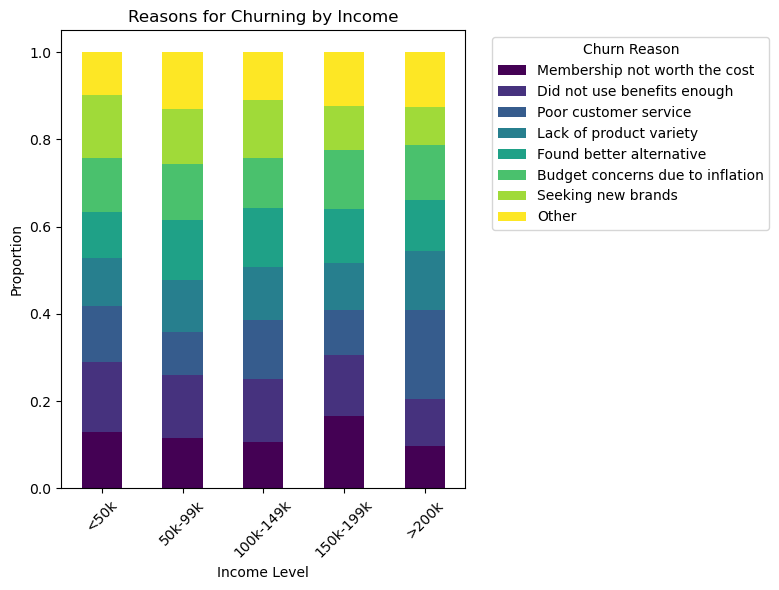

In [11]:
# Create a cross-tabulation of churn reasons vs. income level: 
x_tab = pd.crosstab(survey_df['Income'], survey_df['ChurnReason'])
x_tab = x_tab.drop(columns=8)
order = [3,2,0,1,4] # Reorder income in ascending order
x_tab = x_tab.iloc[order]
x_tab_norm = x_tab.div(x_tab.sum(axis=1), axis=0)


# Plot the cross-tabulation as a stacked barplot
ax = x_tab_norm.plot(kind='bar', stacked='True', figsize=(8,6), colormap='viridis')
plt.ylabel('Proportion')
plt.title('Reasons for Churning by Income')
plt.xlabel('Income Level')
plt.xticks(rotation=45)
plt.legend(labels = x_tab_norm.columns.map(churn_dict), title="Churn Reason", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

In [12]:
from scipy.stats import spearmanr
spearmanr(survey_df['FreqUse'], survey_df['Satisfaction'])
spearmanr(survey_df['InflationPressure'], survey_df['ChurnReason'])

print(f"The Spearman correlation between BenefitValue Net Promoter Score is: {spearmanr(survey_df['BenefitValue'], survey_df['NPS'])[0]}")
print(f"The Spearman correlation between Frequency of use and Satisfaction is: {spearmanr(survey_df['FreqUse'], survey_df['Satisfaction'])[0]}")
print(f"The Spearman correlation between Inflation Pressure and Churn Reason is: {spearmanr(survey_df['InflationPressure'], survey_df['ChurnReason'])[0]}")


The Spearman correlation between BenefitValue Net Promoter Score is: 0.00016409778377583862
The Spearman correlation between Frequency of use and Satisfaction is: 0.004655738479905005
The Spearman correlation between Inflation Pressure and Churn Reason is: -0.013140483560197964


We see that these correlations are close to zero indicating no relationship.

**A/B Testing**

We now perform a t-test for difference in conversion rates and Fisher's exact test on the differences in plan choice (annual vs. monthly). 

Our null hypothesis is that there is no difference in conversion rates between the two treatment groups, while our alternative is that the conversion rate for the variant group is greater than the treatment group. We set a value of alpha = 0.05.

For our test of annual plan selection using Fisher's exact test, our null hypothesis is that the odds ratio of choosing annual plan is equal to or greater than one--the control group is at least as likely as the variant group to choose the annual plan. Our alternative hypothesis is that the odds ratio is less than one, or the control group is less likely than the variant group to choose the annual plan.

In [115]:
from scipy.stats import ttest_ind, fisher_exact
n_ab = 2000

# Group assignment
groups = np.array(['Control'] * 1000 + ['Variant'] * 1000)

# Simulate conversions
control_conversions = np.zeros(1000)
variant_conversions = np.zeros(1000)
annual_plan = np.zeros(1000)
monthly_plan = np.zeros(1000)

# Assign 5.51% conversion rate for control group and 7.62% for test group
control_conversions[:55] = 1
variant_conversions[:76] = 1

annual_plan[:410] = 1
monthly_plan[:590] = 1
annual_plan = ['Annual' if x == 1 else 'Monthly' for x in annual_plan]
monthly_plan = ['Annual' if x == 1 else 'Monthly' for x in monthly_plan]

conversions = np.concatenate([control_conversions, variant_conversions])
plans = np.concatenate([annual_plan, monthly_plan])
# Build A/B test data frame

ab_df = pd.DataFrame({
    'Group': groups,
    'Conversion': conversions,
    'Plan_Type': plans
})

# Basic statistics
print("\n-- A/B Test Dataset Overview --")
print(ab_df.head())

# Analysis
conv_rate_control = ab_df[ab_df['Group'] == 'Control']['Conversion'].mean() * 100
conv_rate_variant = ab_df[ab_df['Group'] == 'Variant']['Conversion'].mean() * 100
lift = (conv_rate_variant - conv_rate_control) / conv_rate_control * 100

print("\nObserved Conversion Rtaes:")
print("\nObserved Conversion Rates:")
print("Control: {:.2f}%".format(conv_rate_control))
print("Variant: {:.2f}%".format(conv_rate_variant))
print("Lift: +{:.0f}%".format(lift))

# One-sided t-test (Variant > Control)
control_data = ab_df[ab_df['Group'] == 'Control']['Conversion']
variant_data = ab_df[ab_df['Group'] == 'Variant']['Conversion']

t_stat, p_value_one_tailed = ttest_ind(variant_data, control_data, alternative='greater')

print("\nOne-sided t-test result:")
print("t-statistic: {:.2f}".format(t_stat))
print("p-value (one-tailed): {:.4f}".format(p_value_one_tailed))

# Chi-square test of independence for plan preference

contingency_table = pd.crosstab(ab_df['Plan_Type'], ab_df['Group'])
fisher_stat, fisher_pvalue = fisher_exact(contingency_table, alternative='less')
print("\nFisher's Exact Test (one-sided) result:")
print("Fisher's Exact Test statistic: {:.2f}".format(fisher_stat))
print("p-value (one-tailed): {:.4f}".format(fisher_pvalue))


-- A/B Test Dataset Overview --
     Group  Conversion Plan_Type
0  Control         1.0    Annual
1  Control         1.0    Annual
2  Control         1.0    Annual
3  Control         1.0    Annual
4  Control         1.0    Annual

Observed Conversion Rtaes:

Observed Conversion Rates:
Control: 5.50%
Variant: 7.60%
Lift: +38%

One-sided t-test result:
t-statistic: 1.90
p-value (one-tailed): 0.0289

Fisher's Exact Test (one-sided) result:
Fisher's Exact Test statistic: 0.48
p-value (one-tailed): 0.0000


In [116]:
contingency_table

Group,Control,Variant
Plan_Type,,
Annual,410,590
Monthly,590,410


Text(0.5, 1.0, 'Higher Conversion Rate in the Variant Group (95% CI)')

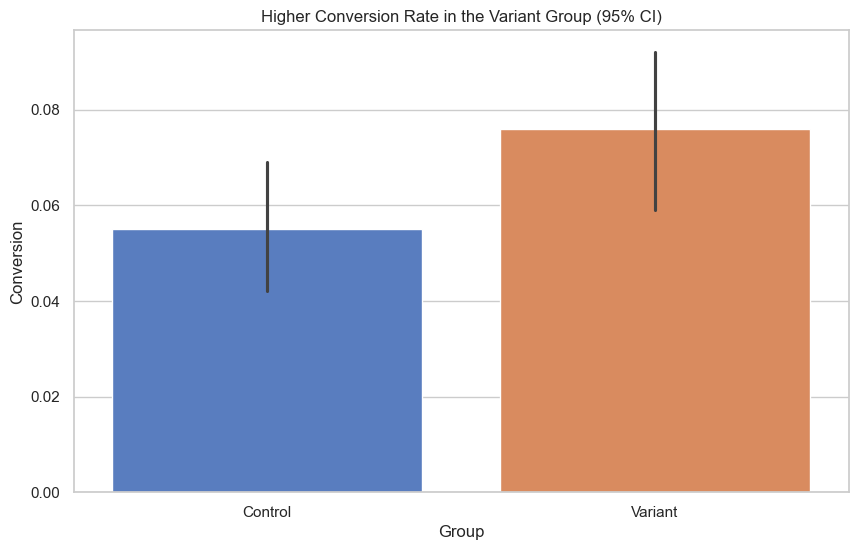

In [117]:
# Visualize results from statistical tests: 

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Group', y='Conversion', data=ab_df, palette="muted")
plt.title('Higher Conversion Rate in the Variant Group (95% CI)')

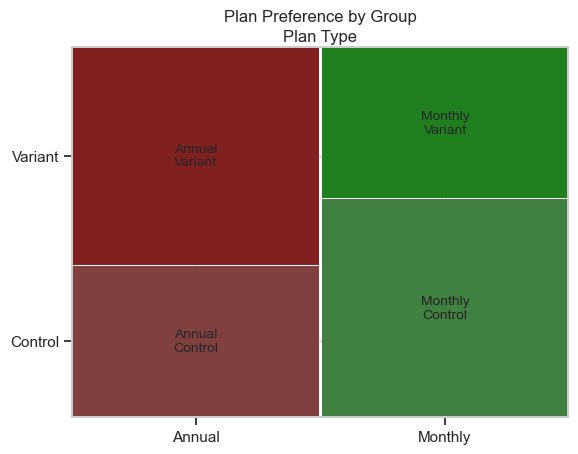

In [121]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 12
mosaic(contingency_table.stack())
plt.xlabel('Plan Type')
plt.ylabel('Group')
plt.title('Plan Preference by Group')
plt.show()